# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Indian restaurant** in **New York**, USA.

This report will try to answer questions such as: Should I place my restaurant in a place where there are a lot of other Indian Restaurants or in a place where there is none or should I try to find some kind of balance between these two extremes?

We will use our data science powers to generate a few most promising neighborhoods based on these criteria.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* find the high rating Indian restaurants in NY and identify them visually on a map
* create several "clusters" of these Indian Restaurants to identfiy potential districts to choose from

We should choose one from these business district and locate our restaurant in the center of it. The closer to the center, the high will be the rent. This is another choise that will be made by us referring to our budget.

To simplify the problem, we will only use the geographic location to cluster the cafes.
For this we will use the "explore" endpoint. The request url is "https://api.foursquare.com/v2/venues/explore" According to the document, in the request, we should pass following parameters: "section=Indian restaurant" and "near=New York, NY". In the response, we are interested in groups.items.categories, groups.items.venue.name, group.items.venue.location. To simplify the problem, we will only use the geographic location to cluster the restaurants.

Following data sources will be needed to extract/generate the required information:
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

## Methodology <a name="methodology"></a>

The basic idea behind the solution is that for locating a new Indian restaurant, you should find where the successful restaurants are now in, since that location is tested by experience. When we get a bunch of restaurants, the data is clustered to find several concentrations that will be targeted by the new restaurants. The intended location is the geographic average of the location of the currently successful restaurants.

#### Let's first download the necessary libraries we will require in our project

In [2]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  25.07 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  38.36 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  52.25 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.39 MB/s
vincent-0.4.4- 100% |###################

#### Setting up Foursquare API

In [3]:
CLIENT_ID = 'LMFK50XGVXRBEYVAQZ2MK35KUQQBVLWF04RVRU5YOILG4TF0' # your Foursquare ID
CLIENT_SECRET = 'HULRNIC3XI30KFCNLRH0E1J1RG4KHVMNPTJV2A3G2R5ZOOB0' # your Foursquare Secret
VERSION = '201902012'
LIMIT = 99
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LMFK50XGVXRBEYVAQZ2MK35KUQQBVLWF04RVRU5YOILG4TF0
CLIENT_SECRET:HULRNIC3XI30KFCNLRH0E1J1RG4KHVMNPTJV2A3G2R5ZOOB0


#### Getting the Latitutude and Longitude through Geolocator

In [4]:
address = '102 North End Ave, New York, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


40.7149555 -74.0153365


#### Passing **Indian Restaurant** in search query

In [5]:
search_query = 'Indian Restaurant'
radius = 5000
print(search_query + ' .... OK!')

Indian Restaurant .... OK!


In [6]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=LMFK50XGVXRBEYVAQZ2MK35KUQQBVLWF04RVRU5YOILG4TF0&client_secret=HULRNIC3XI30KFCNLRH0E1J1RG4KHVMNPTJV2A3G2R5ZOOB0&ll=40.7149555,-74.0153365&v=201902012&query=Indian Restaurant&radius=5000&limit=99'

#### Storing Fourquare results in a file

In [7]:
results = requests.get(url).json()
# results

### Transforming venues into a Dataframe

In [8]:
# assign relevant part of JSON to venues
venues = results['response']['groups'][0]['items']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 28 columns):
reasons.count                          99 non-null int64
reasons.items                          99 non-null object
referralId                             99 non-null object
venue.categories                       99 non-null object
venue.delivery.id                      74 non-null object
venue.delivery.provider.icon.name      74 non-null object
venue.delivery.provider.icon.prefix    74 non-null object
venue.delivery.provider.icon.sizes     74 non-null object
venue.delivery.provider.name           74 non-null object
venue.delivery.url                     74 non-null object
venue.id                               99 non-null object
venue.location.address                 97 non-null object
venue.location.cc                      99 non-null object
venue.location.city                    99 non-null object
venue.location.country                 99 non-null object
venue.location.crossStreet  

#### Creating a Pandas Dataframe

In [9]:
df=pd.DataFrame()
df['venue_ID']=dataframe['venue.id']
df['name']=dataframe['venue.name']
df['lat']=dataframe['venue.location.lat']
df['lng']=dataframe['venue.location.lng']
df.head()

,venue_ID,name,lat,lng
0,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,40.719211,-74.008727
1,5a1e961c1987ec47beed877d,Baar Baar,40.724534,-73.991624
2,5b770657c0cacb002c89bc63,The Kati Roll Company,40.709114,-74.009091
3,575dea4c498e2739e43a27e2,Aahar Indian Cuisine,40.713307,-74.007994
4,4593ed04f964a52050401fe3,The Kati Roll Company,40.729570,-74.000861


### Locating the Indian Restaurants on the map using Folium

In [11]:
# Show the Indian restaurants on the map
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=13)

for lat, lng, name,venue_ID in zip(df['lat'], df['lng'], df['name'],df['venue_ID']):
    
        label = '{}, {}'.format(name, venue_ID)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)
map_newyork

## Analysis <a name="analysis"></a>

We will use K-means clustering algorithm to recommend the locations for the Indian restaurants

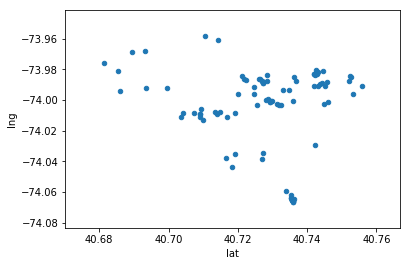

In [13]:
# Cluster these restaurants based on their geographic locations

from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt # plotting library


%matplotlib inline

df.plot(x='lat',y='lng',kind='scatter')

In [14]:
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
df_array=np.array(df[['lat','lng']])
k_means.fit(df_array)
k_labels=pd.DataFrame(k_means.labels_)
k_labels.info()
df['cluster']=k_labels
df.groupby('cluster').count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 1 columns):
0    99 non-null int32
dtypes: int32(1)
memory usage: 476.0 bytes


,venue_ID,name,lat,lng
cluster,,,,
0,44,44,44,44
1,21,21,21,21
2,9,9,9,9
3,25,25,25,25


### Showing the clusters on the map using CircleMarker Method in Folium

In [15]:
# add markers to map

for lat, lng, name,venue_ID,cluster in zip(df['lat'], df['lng'], df['name'],df['venue_ID'],df['cluster']):
    
    if cluster == 0:
        label = '{}, {}'.format(name, venue_ID)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)  
    if cluster == 1:
        label = '{}, {}'.format(name, venue_ID)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)  
    if cluster == 2:
        label = '{}, {}'.format(name, venue_ID)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)  
    if cluster == 3:
        label = '{}, {}'.format(name, venue_ID)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='purple',
            fill=True,
            fill_color='purple',
            fill_opacity=0.7,
            parse_html=False).add_to(map_newyork)  
    
map_newyork

Recommending location for the **Four Cluster** using the mean of the locations

In [16]:
center_location=df.groupby('cluster').mean()
center_location

,lat,lng
cluster,,
0,40.738344,-73.987486
1,40.732583,-74.056640
2,40.694840,-73.976831
3,40.719231,-74.005127


### Showing the recommended locations on the map

In [17]:
# color_list=['blue','red','green','purple']
# Add recommended location on the map
i=0
for lat, lng in zip(center_location['lat'],center_location['lng']):
    folium.Marker([lat,lng], popup='Recommend for Group '+ str(i)).add_to(map_newyork)
    i=i+1
map_newyork

## Results and Discussion <a name="results"></a>

This solution is based purely on the geographic location, which is quite good in most cases. Since in the business of restaurants, the right location is one of the most important decisions to make. Nevertheless, if we could find more information on each cluster, it will improve the solution further.

## Conclusion <a name="conclusion"></a>

The clustering is very useful and intuitive to solve the problem related to geographic data. We should also pay attention to the outcomes of the clustering, especially when it yields a result of different ideas of a 'business circle' in a city. It has two potential reasons. One is that the clustering is simply wrong. But more likely, the result may present a new business opportunity. In the latter case, we should examine the features we included in the model to find the cause of the result. If we can identify the reason that causes the clustering, it might be a valuable business insight.

Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.